Step 2-5 Have a similar structure. They makes a proposal model to explain the data. They show an example of the type of output the model creates. Then it says how its updating it parameters. Finaly we show the process of fitting on the data.

In [4]:
import Random
using  Plots, CSV, Gen
using DataFrames: DataFrame
include("../step01-importing-data/utilities/read-files.jl")
DF = ReadDF("../../data/Proccesed/DetrendedCov.csv")
xs = DF.Date
ys = DF.DetrendedN1
include("utilities/visualize.jl")



(process:47636): GLib-GIO-WARNING **: 10:11:35.630: Unexpectedly, UWP app `HaukeGtze.7-ZipFileManagerUnofficial_1.1900.3.0_x64__6bk20wvc8rfx2' (AUMId `HaukeGtze.7-ZipFileManagerUnofficial_6bk20wvc8rfx2!zFM.exe') supports 36 extensions but has no verbs

(process:47636): GLib-GIO-WARNING **: 10:11:35.677: Unexpectedly, UWP app `HaukeGtze.PuTTYSSHClient_1.76.2.0_x64__6bk20wvc8rfx2' (AUMId `HaukeGtze.PuTTYSSHClient_6bk20wvc8rfx2!pageant.exe') supports 1 extensions but has no verbs


make_constraints (generic function with 1 method)

This is our proposal model. It has 2 main parts. It has randomly generated parameters and some models from the xs input and the random parameters to the output. In this case it is modeling a simple linear model with some points flagged as outliers.

In [5]:
@gen function Linear_regression_with_outliers(xs::Vector{<:Real})
    # First, generate some parameters of the model. We make these
    # random choices, because later, we will want to infer them
    # from data. The distributions we use here express our assumptions
    # about the parameters: we think the slope and intercept won't be
    # too far from 0; that the noise is relatively small; and that
    # the proportion of the dataset that don't fit a linear relationship
    # (outliers) could be anything between 0 and 1.
    slope ~ normal(0, 1000)
    intercept ~ normal(0, 1000)
    noise ~ gamma(100, 100)
    prob_outlier ~ uniform(0, 1)
    
    # Next, we generate the actual y coordinates.
    n = length(xs)
    ys = Float64[]
    
    for i = 1:n
        # Decide whether this point is an outlier, and set
        # mean and standard deviation accordingly
        if ({:data => i => :is_outlier} ~ bernoulli(prob_outlier))
            (mu, std) = (0., 1000000)
        else
            (mu, std) = (xs[i] * slope + intercept, noise)
        end
        # Sample a y value for this point
        push!(ys, {:data => i => :y} ~ normal(mu, std))
    end
    ys
end;

This is a helper function to let the visualization code know what the ys values look like without the outliers

In [115]:
function serialize_trace(trace)
    (xs,) = Gen.get_args(trace)
    n = length(xs)
    Dict(:slope => trace[:slope],
         :inlier_std => trace[:noise],
         :points => zip(xs, [trace[:data => i => :y] for i in 1:length(xs)]),
         :xs => xs,
         :ys => [xs[i] * trace[:slope] + trace[:intercept] for i in 1:n],
         :intercept => trace[:intercept],
         :outliers => [trace[:data => i => :is_outlier] for i in 1:length(xs)])
end

serialize_trace (generic function with 1 method)

This is the visualize code we are using for the rest of this steps. it uses each steps serialize_trace function to find the info needed to graph the data along with the model.

In [116]:
function visualize_trace(trace::Trace; title="")
    trace = serialize_trace(trace)
    #Graph points
    outliers = [pt for (pt, outlier) in zip(trace[:points], trace[:outliers]) if outlier]
    inliers =  [pt for (pt, outlier) in zip(trace[:points], trace[:outliers]) if !outlier]
    PLT = Plots.scatter(map(first, inliers), map(last, inliers), markercolor="blue", label=nothing) 
    PLT = Plots.scatter!(map(first, outliers), map(last, outliers), markercolor="red", label=nothing)

    #Graph Line
    PLT = Plots.plot!(trace[:xs], trace[:ys], color = "black", lw = 3, label = nothing)


    #LogPlot
    ExpPLT = Plots.scatter(map(first, inliers), log_modulus.(map(last, inliers)), markercolor="blue", label=nothing) 
    ExpPLT = Plots.scatter!(map(first, outliers), log_modulus.(map(last, outliers)), markercolor="red", label=nothing)
    ExpPLT = Plots.plot!(trace[:xs], log_modulus.(trace[:ys]), color = "black", lw = 3, label = nothing)
    
    DuoPlot = plot(PLT,ExpPLT,title=title)
    return DuoPlot
end

visualize_trace (generic function with 1 method)

Before we look at the model on the actual data it makes sense to look at what a generic output of the data is.

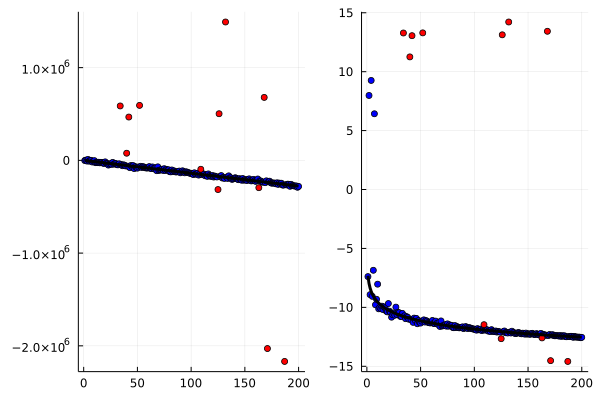

In [147]:
ts = collect(range(1, stop=200, length=200))
traces = Gen.simulate(Linear_regression_with_outliers, (ts,));
visualize_trace(traces)

What we want is for the code to find the best set of random parameters for the data. We do this by setting the output of the model to what our code has as the outputs. Then we can use Markov chain Monte Carlo to locate the best set of parameters.

In [118]:
function make_constraints(ys::Vector{Float64})
    constraints = Gen.choicemap()
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    constraints
end;

This function is what we use to tell the Markov chain Monte Carlo how to function. We update the parameters using the Metropolis Hasting algorithm in order from high level random variable down to low level random variable

In [120]:
# Perform a single block resimulation update of a trace.
function block_resimulation_update(tr)
    # Block 1: Update the line's parameters
    line_params = select(:noise, :slope, :intercept)
    (tr, _) = mh(tr, line_params)
    
    # Blocks 2-N+1: Update the outlier classifications
    (xs,) = get_args(tr)
    n = length(xs)
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block N+2: Update the prob_outlier parameter
    (tr, _) = mh(tr, select(:prob_outlier))
    
    # Return the updated trace
    tr
end;

┌ Info: Saved animation to 
│   fn = C:\Users\marli\AppData\Local\Temp\jl_Nj2lCBM3vR.gif
└ @ Plots C:\Users\marli\.julia\packages\Plots\rDbWY\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\marli\\AppData\\Local\\Temp\\jl_Nj2lCBM3vR.gif")
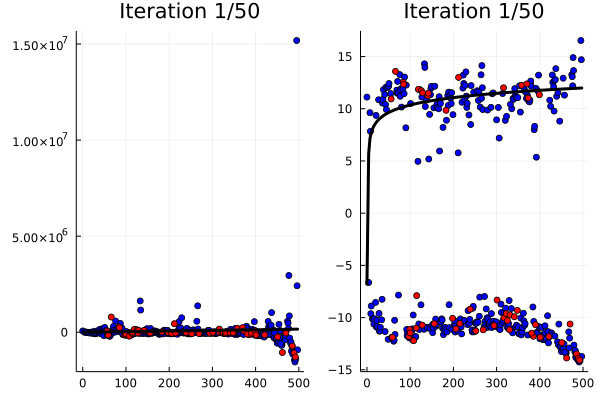

In [148]:
observations = make_constraints(ys);
t, = generate(Linear_regression_with_outliers, (xs,), observations)
dur = 50
viz = Plots.@animate for i in 1:dur
    global t
    t = block_resimulation_update(t)
    visualize_trace(t; title="Iteration $i/$dur")
end;
gif(viz)